In [1]:
from color_code_stim import *

# ColorCode object and its attributes

**Initialization of a ColorCode object**

Currently support only the logical idling gate of a triangular color code, which is preceded by a logical-$Z$ initialization (to its $+1$ eigenstate) and followed by a logical-$Z$ measurement.

ex) 5-round idling gate of distance-5 color code under circuit-level noise of strength 1e-3.

In [2]:
colorcode = ColorCode(d=5,
                      rounds=5,
                      cnot_schedule='LLB',  # Default CNOT schedule optimized in our paper.
                      p_circuit=1e-3)

**Tanner graph of the code**

In [3]:
graph = colorcode.tanner_graph  # igraph.Graph object
print('Total number of vertices:', len(graph.vs))
print('Total number of edges:', len(graph.es))
print()
print('Some examples of vertices:')
for v in graph.vs[:10]:
    print(v)

Total number of vertices: 37
Total number of edges: 84

Some examples of vertices:
igraph.Vertex(<igraph.Graph object at 0x107034d40>, 0, {'x': 0, 'y': 0, 'qid': 0, 'pauli': None, 'color': None, 'boundary': 'rg', 'name': '0-0'})
igraph.Vertex(<igraph.Graph object at 0x107034d40>, 1, {'x': 2, 'y': 0, 'qid': 1, 'pauli': None, 'color': None, 'boundary': 'r', 'name': '2-0'})
igraph.Vertex(<igraph.Graph object at 0x107034d40>, 2, {'x': 4, 'y': 0, 'qid': 2, 'pauli': 'Z', 'color': 'g', 'boundary': 'r', 'name': '4-0-Z'})
igraph.Vertex(<igraph.Graph object at 0x107034d40>, 3, {'x': 4, 'y': 0, 'qid': 3, 'pauli': 'X', 'color': 'g', 'boundary': 'r', 'name': '4-0-X'})
igraph.Vertex(<igraph.Graph object at 0x107034d40>, 4, {'x': 6, 'y': 0, 'qid': 4, 'pauli': None, 'color': None, 'boundary': 'r', 'name': '6-0'})
igraph.Vertex(<igraph.Graph object at 0x107034d40>, 5, {'x': 8, 'y': 0, 'qid': 5, 'pauli': None, 'color': None, 'boundary': 'r', 'name': '8-0'})
igraph.Vertex(<igraph.Graph object at 0x107034

**Drawing the tanner graph**

qubits: black, checks: red/green/blue

For simplicity, only one of the two checks of each face is visible.

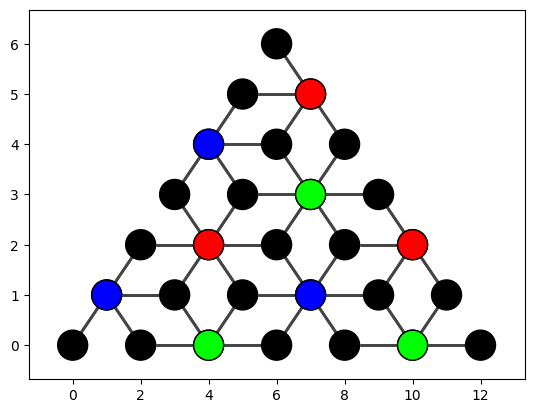

In [4]:
plt, ax = plt.subplots()
colorcode.draw_tanner_graph(ax=ax, show_axes=True)

**Circuit**

In [5]:
circuit = colorcode.circuit  # stim.Circuit object

**Detectors**

Detectors have their own detector IDs.

A detector is specified by the round (integer) it belongs to and the ancillary qubit (igraph.Vertex) involved in it.

In [18]:
num_detectors = colorcode.circuit.num_detectors
print("Number of detectors:", num_detectors)
print("Some examples of detectors:")
for det_id in range(0, num_detectors, 10):
    anc, rnd = colorcode.get_detector(det_id)
    print(f"id = {det_id}: round {rnd}, ancillary qubit {anc}")

Number of detectors: 90
Some examples of detectors:
id = 0: round 0, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x107034d40>, 2, {'x': 4, 'y': 0, 'qid': 2, 'pauli': 'Z', 'color': 'g', 'boundary': 'r', 'name': '4-0-Z'})
id = 10: round 1, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x107034d40>, 6, {'x': 10, 'y': 0, 'qid': 6, 'pauli': 'Z', 'color': 'g', 'boundary': 'r', 'name': '10-0-Z'})
id = 20: round 1, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x107034d40>, 10, {'x': 1, 'y': 1, 'qid': 10, 'pauli': 'X', 'color': 'b', 'boundary': 'g', 'name': '1-1-X'})
id = 30: round 2, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x107034d40>, 13, {'x': 7, 'y': 1, 'qid': 13, 'pauli': 'Z', 'color': 'b', 'boundary': None, 'name': '7-1-Z'})
id = 40: round 2, ancillary qubit igraph.Vertex(<igraph.Graph object at 0x107034d40>, 19, {'x': 4, 'y': 2, 'qid': 19, 'pauli': 'X', 'color': 'r', 'boundary': None, 'name': '4-2-X'})
id = 50: round 3, ancillary qubit igraph.Ver

# Sampling & Decoding with the Concatenated MWPM decoder

## Shortcut: sampling & decoding & stats at once

In [7]:
alpha = 0.01
num_fails, pfail, delta_pfail = colorcode.simulate(
    10000,  # Number of shots
    get_stats=True,  # Whether to get statistics. If False, only the number of failures is returned.
    alpha=alpha,  # Significance level of the confidence interval of pfail
    verbose=True
)

Sampling...
Decomposing detector error model...
Decoding...
color r, step-1 decoding..
color r, step-2 decoding..
color r, postprocessing..
color g, step-1 decoding..
color g, step-2 decoding..
color g, postprocessing..
color b, step-1 decoding..
color b, step-2 decoding..
color b, postprocessing..
Postprocessing...


In [8]:
print('Number of failures =', num_fails)
print(f'pfail = {pfail:.2e} +- {delta_pfail:.2e} ({(1 - alpha) * 100}% confidence interval)')

Number of failures = 26
pfail = 2.89e-03 +- 1.36e-03 (99.0% confidence interval)


## Step-by-step

**Sampling detector and observable outcomes**

In [9]:
det, obs = colorcode.sample(10000)

`det[i,j]` is `True` if and only if the detector with id `j` in the `i`th sample has an outcome of $-1$.

In [10]:
det

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

`obs[i]` is `True` if and only if the logical observable of the `i`th sample has an outcome of $-1$.

In [11]:
obs

array([False, False, False, ..., False, False, False])

**Decompose the detector error model**

In [12]:
dems = {}
for color in ['r', 'g', 'b']:
    dem1, dem2 = colorcode.decompose_detector_error_model(color)
    dems[color] = dem1, dem2  # stim.DetectorErrorModel

**Decode using the concatenated MWPM decoder**

In [13]:
preds_obs, best_color = colorcode.decode(det, dems, verbose=True, get_color=True)

color r, step-1 decoding..
color r, step-2 decoding..
color r, postprocessing..
color g, step-1 decoding..
color g, step-2 decoding..
color g, postprocessing..
color b, step-1 decoding..
color b, step-2 decoding..
color b, postprocessing..


In [14]:
preds_obs  # Predictions of logical observables

array([False, False, False, ..., False, False, False])

In [15]:
best_color  # Selected best colors

array(['r', 'r', 'r', ..., 'r', 'r', 'r'], dtype='<U1')

**Check failures**

In [16]:
fails = np.logical_xor(obs, preds_obs)
fails

array([False, False, False, ..., False, False, False])

In [17]:
print("Number of failures:", np.sum(fails))

Number of failures: 32
